In [2]:
# Import the packages we'll be using
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt

In [3]:
# Set up our Cohen's d function
def cohens_d (x,y):
    n1 = x.shape[0]
    n2 = y.shape[0]
    sd = (((n1 - 1) * x.var() + (n2 - 1) * y.var())/(n1 + n2 - 2))**0.5
    return ((x.mean()-y.mean())/sd)

In [4]:
# Define more concise headers for the data
headers = ["timestamp","level","country","is_online",
           "first_survey","agree","primary_mode","preferred_mode",
           "why_mode","platforms_used","methods_used",
           "techniques_outside","remote_enjoy","remote_motivated",
           "remote_satisfied","remote_engaging","remote_distracted",
           "remote_questions","remote_changes","prior_enjoy",
           "prior_motivated","prior_satisfied","prior_engaging",
           "prior_distracted","prior_questions","prior_changes",
           "preference","why_preference"]

# Read in the raw data
data = pd.read_csv("RLData.csv", skiprows=[0], names=headers, na_values="?")

In [5]:
# Define some other lists that will be useful

# List of just the Likert questions about remote instructions
remote_survey_q = ["remote_enjoy","remote_motivated",
                   "remote_satisfied","remote_engaging",
                   "remote_distracted","remote_questions"]
change_survey_q = ["change_enjoy","change_motivated",
                   "change_satisfied","change_engaging",
                   "change_distracted","change_questions"]
remote_q_long = ["I enjoy having courses online",
                 "I feel motivated to learn",
                 "I am satisfied with the instruction\nof my online courses",
                 "My courses are engaging",
                 "I am often distracted when doing\ncourse work / attending classes",
                 "I often ask questions, comment, join discussions"]
change_q_long = ["I enjoy",
                 "I feel motivated to learn",
                 "I am satisfied with the instruction",
                 "My courses are engaging",
                 "I am often distracted when doing\ncourse work / attending classes",
                 "I often ask questions, comment, join discussions"]

In [6]:
# Drop the rows that we're not going to be using
data_2 = data.drop(["timestamp","agree","why_mode",
                        "remote_changes","prior_changes",
                        "why_preference"], axis=1)

In [7]:
# Recode Likert responses into numerical code
likert_dict = {"Strongly Disagree": 1, "Disagree": 2, "Neutral": 3, 
               "Agree": 4, "Strongly Agree": 5}
likert_code = {"remote_enjoy":       likert_dict,
               "remote_motivated":   likert_dict,
               "remote_satisfied":   likert_dict,
               "remote_engaging":    likert_dict,
               "remote_distracted":  likert_dict,
               "remote_questions":   likert_dict,
               "prior_enjoy":       likert_dict,
               "prior_motivated":   likert_dict,
               "prior_satisfied":   likert_dict,
               "prior_engaging":    likert_dict,
               "prior_distracted":  likert_dict,
               "prior_questions":   likert_dict}
data.replace(likert_code, inplace=True)

In [8]:
# Only choosing german respondents 

# Acquire data from Germany only 
germany_data = data[data["country"] == "Germany"]
germany_data = germany_data[germany_data["level"] != "High school/A-levels/Gymnasium"]
len(germany_data)

# Acquire data from UK 
uk_data = data[data["country"] == "United Kingdom"] 
uk_data = uk_data[uk_data["level"] == "Undergraduate (studying for associates or bachelors degrees)"] 

# germany_data['primary_mode'].iloc[0:5]
print('Number of respondents in Germany:', len(germany_data))

print('Number of respondents in the UK:', len(uk_data))



Number of respondents in Germany: 350
Number of respondents in the UK: 2085


In [9]:
# Recode Primary mode entries into shorter things
modes = {"primary_mode":   {"Live classes (ie: Zoom; Google Meet etc.)": "live",
                            "Uploaded or emailed Materials": "upload",
                            "Recorded Lectures": "recorded",
                            "Discussion forums/chats": "chat"}}
germany_data.replace(modes, inplace=True)

germany_data['primary_mode'].iloc[0:5]



32         live
73     recorded
102        live
114    recorded
184        live
Name: primary_mode, dtype: object

In [10]:
# Recode Outside Techniques
techniques = {"techniques_outside":   {"Video Content": "video_content",
                                       "Video Lectures": "video_lectures",
                                       "Discussion/Chat Forums": "chat",
                                       "Assignments/un-proctored exams": "assignments",
                                       "Email Q&A with instructors": "email",
                                       "Posted readings/study material": "readings",
                                       "Live office hours": "office_hours"}}
germany_data.replace(techniques, inplace=True)

In [11]:
# Defining Active and Passive methods of learning 

germany_data["active"] = germany_data["methods_used"].str.contains(pat='In-class assessments/quizzes|Small group activities|Whole class discussion/debate|Q&A with students\' questions|Classroom chat')
# Active methods: 
# - In-class assessments/quizzes 
# - Small group activities
# - Class discussion/debate 
# - Q&A with students 
# - Classroom chats 

germany_data["passive"] = germany_data["methods_used"].str.contains(pat='Lecture/presentation|Explanation using Diagrams/White Boards/other media')
# Passive methods: 
# - Lecture Presentation 
# - Explanation using diagrams 
# - White boards
# - Other media 

germany_data["fully_active"] = germany_data["methods_used"].str.contains(pat='In-class assessments/quizzes|Small group activities|Whole class discussion/debate')
# Fully Active methods:
# - In-class assessments
# - Small group activities 
# - Whole class discussion/debats 

germany_data["partly_active"] = germany_data["methods_used"].str.contains(pat='Q&A with students\' questions|Classroom chat')
# Partly Active methods:
# - Q&A with students/questions 
# - Classroom chats 

    
### Create frames for undergraduates learning synchronously and asynchronously
ug_sync = germany_data[germany_data.primary_mode.eq("live")]
ug_async = germany_data[germany_data["primary_mode"] != "live"]

### Create frames for active / passive / mixed methods
ug_active_only = germany_data[germany_data.active & (germany_data.passive==False)]
ug_passive_only = germany_data[(germany_data.active==False) & (germany_data.passive.eq(True))]
ug_act_pass_mix = germany_data[germany_data.active & germany_data.passive]

ug_fully_active = germany_data[germany_data.fully_active.eq(True)]
ug_partly_active = germany_data[germany_data.partly_active.eq(True)]
ug_passive = germany_data[germany_data.passive.eq(True)]

# Create frames to categorize students by the *most* active technique they list 
ug_f_act = germany_data[germany_data.fully_active.eq(True)]
ug_p_act = germany_data[germany_data.fully_active.eq(False) & germany_data.partly_active.eq(True)]
ug_pass = germany_data[germany_data.fully_active.eq(False) & germany_data.partly_active.eq(False) & germany_data.passive.eq(True)]


# print(len(ug_active_only), len(ug_passive_only), len(ug_act_pass_mix))

### Function for comparing active vs passive sample sizes 
def active_vs_passive(data):
    active_only = data[data.active & (data.passive==False)]
    passive_only = data[(data.active==False)  & (data.passive.eq(True))]
    mixed = data[data.active & data.passive]
    none = data[(data.active == False) & (data.passive == False)]

    return ["active only:",len(active_only)], ["passive only:", len(passive_only)], ["mixed:", len(mixed)], ['none:', len(none)]

print(len(germany_data))
active_vs_passive(germany_data)

350


(['active only:', 36], ['passive only:', 49], ['mixed:', 242], ['none:', 23])

In [12]:
germany_data.iloc[0:3,9:-3]

# len(germany_data["active"])
len(germany_data)
# len(ug_act_pass_mix)

germany_data.columns



Index(['timestamp', 'level', 'country', 'is_online', 'first_survey', 'agree',
       'primary_mode', 'preferred_mode', 'why_mode', 'platforms_used',
       'methods_used', 'techniques_outside', 'remote_enjoy',
       'remote_motivated', 'remote_satisfied', 'remote_engaging',
       'remote_distracted', 'remote_questions', 'remote_changes',
       'prior_enjoy', 'prior_motivated', 'prior_satisfied', 'prior_engaging',
       'prior_distracted', 'prior_questions', 'prior_changes', 'preference',
       'why_preference', 'active', 'passive', 'fully_active', 'partly_active'],
      dtype='object')

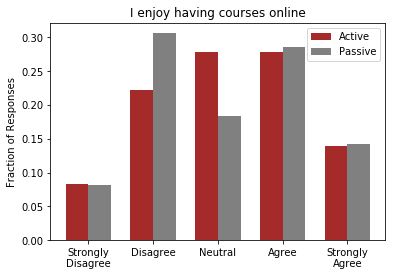

MannwhitneyuResult(statistic=853.5, pvalue=0.39881764976327233)
Active Only  3.17
Passive Only 3.1
Cohen's d = 0.053


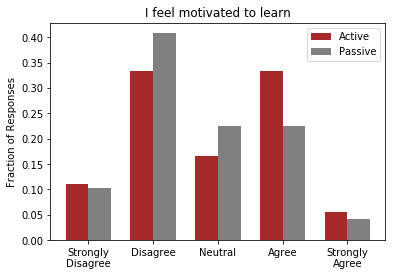

MannwhitneyuResult(statistic=797.0, pvalue=0.2163662894605129)
Active Only  2.89
Passive Only 2.69
Cohen's d = 0.18


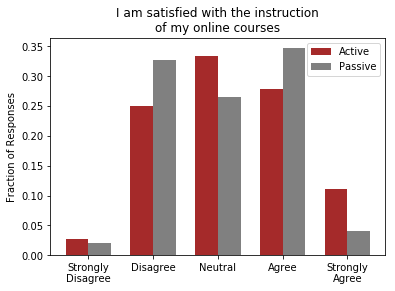

MannwhitneyuResult(statistic=823.5, pvalue=0.29503426662387866)
Active Only  3.19
Passive Only 3.06
Cohen's d = 0.13


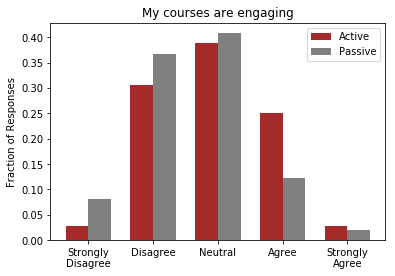

MannwhitneyuResult(statistic=717.5, pvalue=0.06111191617899206)
Active Only  2.94
Passive Only 2.63
Cohen's d = 0.35


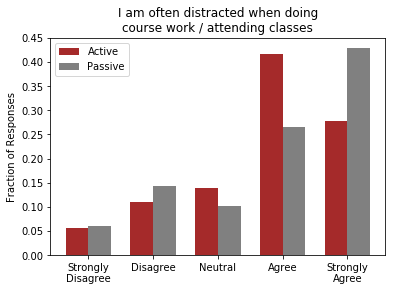

MannwhitneyuResult(statistic=799.0, pvalue=0.22112914389387084)
Active Only  3.75
Passive Only 3.86
Cohen's d = -0.087


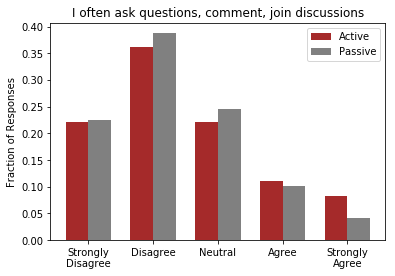

MannwhitneyuResult(statistic=843.5, pvalue=0.36237056287780156)
Active Only  2.47
Passive Only 2.35
Cohen's d = 0.11


In [13]:
### ACTIVE VS PASSIVE ### 

actcount = np.zeros((6,5))
pascount = np.zeros((6,5))

for i in range (6):
    for j in range (5):
        actcount[i,j] = ug_active_only[remote_survey_q[i]].value_counts(normalize=True)[j+1] 
        pascount[i,j] = ug_passive_only[remote_survey_q[i]].value_counts(normalize=True)[j+1]

for q in range (6):
    ind = np.arange(5) 
    width = 0.35       
    plt.bar(ind, actcount[q], width, label='Active', color = "brown")
    plt.bar(ind + width, pascount[q], width, label='Passive', color = "gray")

    plt.ylabel('Fraction of Responses')
    plt.title(remote_q_long[q])

    plt.xticks(ind + width / 2, ('Strongly\nDisagree', 'Disagree',
                                 'Neutral', 'Agree', 'Strongly\nAgree'))
    plt.legend(loc='best')
    plt.show()
    print (stats.mannwhitneyu(ug_active_only[remote_survey_q[q]],ug_passive_only[remote_survey_q[q]]))
    print ("Active Only ","{:.3}".format(ug_active_only[remote_survey_q[q]].mean()))
    print ("Passive Only","{:.3}".format(ug_passive_only[remote_survey_q[q]].mean()))
    print ("Cohen's d =","{:.2}".format(cohens_d(ug_active_only[remote_survey_q[q]],ug_passive_only[remote_survey_q[q]])))
    

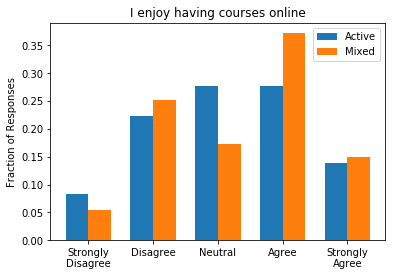

MannwhitneyuResult(statistic=4047.5, pvalue=0.23875418705245033)
Active Only  3.17
Mixed 3.31
Cohen's d = -0.12


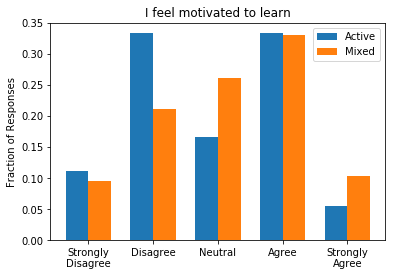

MannwhitneyuResult(statistic=3844.0, pvalue=0.11992716885882959)
Active Only  2.89
Mixed 3.14
Cohen's d = -0.21


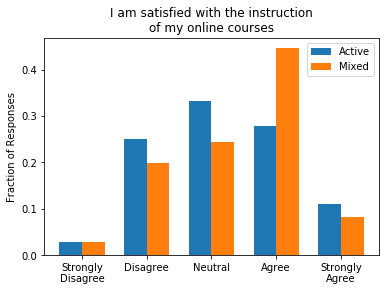

MannwhitneyuResult(statistic=3904.5, pvalue=0.14509387222850967)
Active Only  3.19
Mixed 3.36
Cohen's d = -0.16


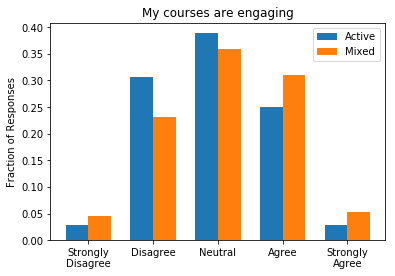

MannwhitneyuResult(statistic=3940.5, pvalue=0.16690131406339442)
Active Only  2.94
Mixed 3.1
Cohen's d = -0.16


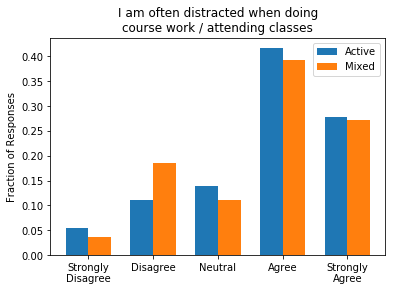

MannwhitneyuResult(statistic=4222.0, pvalue=0.37795621071278557)
Active Only  3.75
Mixed 3.68
Cohen's d = 0.062


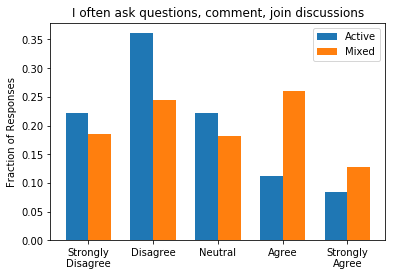

MannwhitneyuResult(statistic=3554.0, pvalue=0.034080838900853415)
Active Only  2.47
Mixed 2.9
Cohen's d = -0.33


In [15]:
### ACTIVE VS MIXED ### 

actcount = np.zeros((6,5))
mixcount = np.zeros((6,5))

for i in range (6):
    for j in range (5):
        actcount[i,j] = ug_active_only[remote_survey_q[i]].value_counts(normalize=True)[j+1] 
        mixcount[i,j] = ug_act_pass_mix[remote_survey_q[i]].value_counts(normalize=True)[j+1]

for q in range (6):
    ind = np.arange(5) 
    width = 0.35       
    plt.bar(ind, actcount[q], width, label='Active')
    plt.bar(ind + width, mixcount[q], width, label='Mixed')

    plt.ylabel('Fraction of Responses')
    plt.title(remote_q_long[q])

    plt.xticks(ind + width / 2, ('Strongly\nDisagree', 'Disagree',
                                 'Neutral', 'Agree', 'Strongly\nAgree'))
    plt.legend(loc='best')
    plt.show()
    print (stats.mannwhitneyu(ug_active_only[remote_survey_q[q]],ug_act_pass_mix[remote_survey_q[q]]))
    print ("Active Only ","{:.3}".format(ug_active_only[remote_survey_q[q]].mean()))
    print ("Mixed","{:.3}".format(ug_act_pass_mix[remote_survey_q[q]].mean()))
    print ("Cohen's d =","{:.2}".format(cohens_d(ug_active_only[remote_survey_q[q]],ug_act_pass_mix[remote_survey_q[q]])))
    


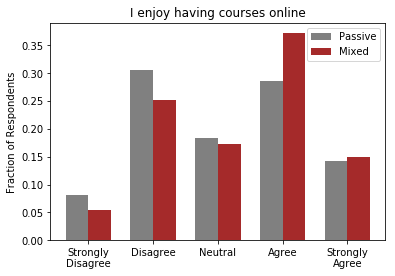

MannwhitneyuResult(statistic=5355.5, pvalue=0.13404375517669792)
Passive Only  3.1
Mixed 3.31
Cohen's d = -0.18


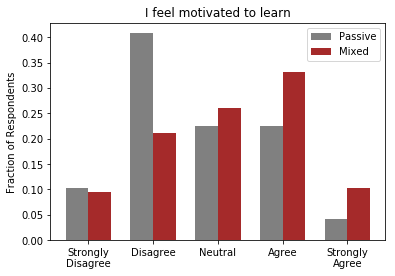

MannwhitneyuResult(statistic=4594.0, pvalue=0.00513182669828595)
Passive Only  2.69
Mixed 3.14
Cohen's d = -0.39


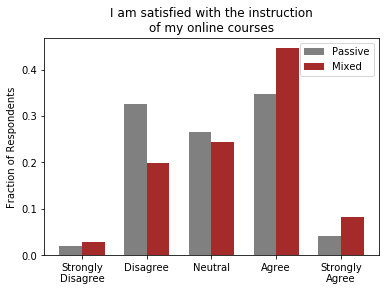

MannwhitneyuResult(statistic=4918.0, pvalue=0.02335020653941)
Passive Only  3.06
Mixed 3.36
Cohen's d = -0.3


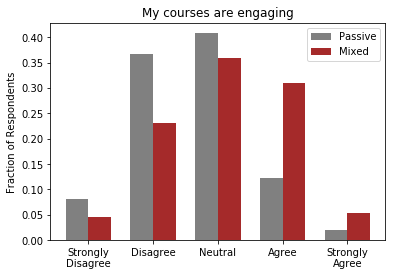

MannwhitneyuResult(statistic=4318.5, pvalue=0.0008492709863837704)
Passive Only  2.63
Mixed 3.1
Cohen's d = -0.49


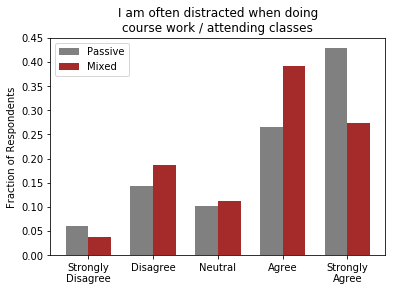

MannwhitneyuResult(statistic=5227.0, pvalue=0.08609531097862244)
Passive Only  3.86
Mixed 3.68
Cohen's d = 0.15


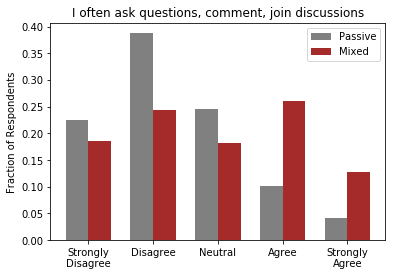

MannwhitneyuResult(statistic=4525.5, pvalue=0.0037197018717702954)
Passive Only  2.35
Mixed 2.9
Cohen's d = -0.43


In [17]:
### PASSIVE VS MIXED ### 
pascount = np.zeros((6,5))
mixcount = np.zeros((6,5))

for i in range (6):
    for j in range (5):
        pascount[i,j] = ug_passive_only[remote_survey_q[i]].value_counts(normalize=True)[j+1] 
        mixcount[i,j] = ug_act_pass_mix[remote_survey_q[i]].value_counts(normalize=True)[j+1]

for q in range (6):
    ind = np.arange(5) 
    width = 0.35       
    plt.bar(ind, pascount[q], width, label='Passive', color = 'gray')
    plt.bar(ind + width, mixcount[q], width, label='Mixed', color = 'brown')

    plt.ylabel('Fraction of Respondents')
    plt.title(remote_q_long[q])

    plt.xticks(ind + width / 2, ('Strongly\nDisagree', 'Disagree',
                                 'Neutral', 'Agree', 'Strongly\nAgree'))
    plt.legend(loc='best')
    plt.show()
    print (stats.mannwhitneyu(ug_passive_only[remote_survey_q[q]],ug_act_pass_mix[remote_survey_q[q]]))
    print ("Passive Only ","{:.3}".format(ug_passive_only[remote_survey_q[q]].mean()))
    print ("Mixed","{:.3}".format(ug_act_pass_mix[remote_survey_q[q]].mean()))
    print ("Cohen's d =","{:.2}".format(cohens_d(ug_passive_only[remote_survey_q[q]],ug_act_pass_mix[remote_survey_q[q]])))
    

4.0    0.254386
2.0    0.245614
3.0    0.210526
1.0    0.171053
5.0    0.118421
Name: remote_questions, dtype: float64
2.0    0.32
1.0    0.28
4.0    0.18
5.0    0.14
3.0    0.08
Name: remote_questions, dtype: float64


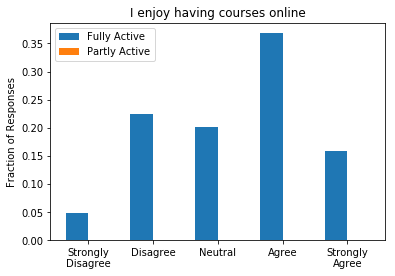

MannwhitneyuResult(statistic=4904.5, pvalue=0.08261322793203735)
Fully Active  3.36
Partly Active 2.96
Cohen's d = 0.23


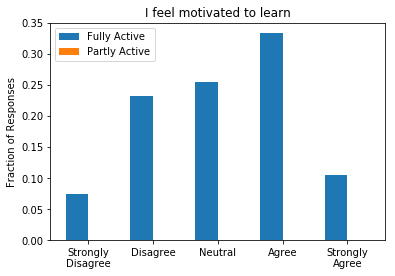

MannwhitneyuResult(statistic=4259.5, pvalue=0.003498010723267023)
Fully Active  3.16
Partly Active 2.84
Cohen's d = 0.42


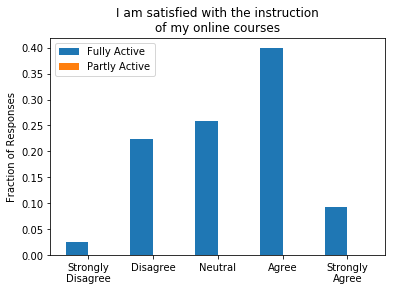

MannwhitneyuResult(statistic=4812.0, pvalue=0.05533396834337622)
Fully Active  3.31
Partly Active 3.46
Cohen's d = 0.25


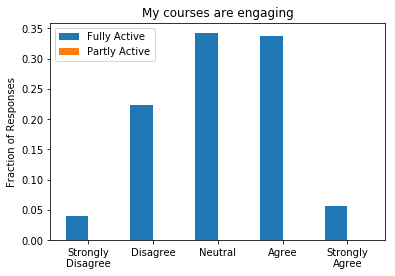

MannwhitneyuResult(statistic=3899.5, pvalue=0.00026207063596466563)
Fully Active  3.15
Partly Active 2.74
Cohen's d = 0.54


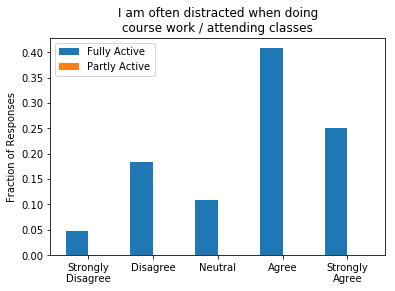

MannwhitneyuResult(statistic=4796.0, pvalue=0.05233696660966854)
Fully Active  3.63
Partly Active 3.96
Cohen's d = -0.19


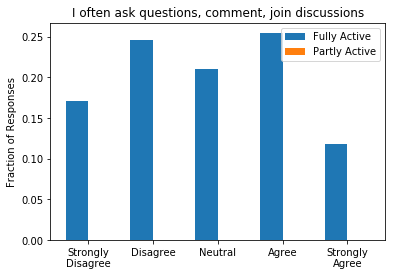

MannwhitneyuResult(statistic=4204.5, pvalue=0.002690507187618964)
Fully Active  2.9
Partly Active 2.58
Cohen's d = 0.44


In [58]:
dim = (6,5)
factcount = np.zeros(dim)
pactcount = np.zeros(dim)

for i in range (6):
    for j in range (5):
        factcount[i,j] = ug_f_act[remote_survey_q[i]].value_counts(normalize=True)[j+1]
#         print(factcount)
#         passcount[i,j] = ug_passive_only[remote_survey_q[i]].value_counts(normalize=True)[j+1] 
#         pactcount[i,j] = ug_p_act[remote_survey_q[i]].value_counts(normalize=True)[j+1]

print(ug_f_act[remote_survey_q[5]].value_counts(normalize=True))
print(ug_p_act[remote_survey_q[5]].value_counts(normalize=True))


for q in range (6):
    ind = np.arange(5) 
    width = 0.35       
    plt.bar(ind, factcount[q], width, label='Fully Active')
    plt.bar(ind + width, pactcount[q], width, label='Partly Active')

    plt.ylabel('Fraction of Responses')
    plt.title(remote_q_long[q])

    plt.xticks(ind + width / 2, ('Strongly\nDisagree', 'Disagree',
                                 'Neutral', 'Agree', 'Strongly\nAgree'))
    plt.legend(loc='best')
    plt.show()
    print (stats.mannwhitneyu(ug_f_act[remote_survey_q[q]],ug_passive_only[remote_survey_q[q]]))
    print ("Fully Active ","{:.3}".format(ug_f_act[remote_survey_q[q]].mean()))
    print ("Partly Active","{:.3}".format(ug_p_act[remote_survey_q[q]].mean()))
    print ("Cohen's d =","{:.2}".format(cohens_d(ug_f_act[remote_survey_q[q]],ug_passive_only[remote_survey_q[q]])))
    

In [6]:
# dim = (6,5)
# factcount = np.zeros(dim)
# pactcount = np.zeros(dim)
# passcount = np.zeros(dim)


# for i in range (6):
#     for j in range (5):
#         factcount[i,j] = ug_f_act[remote_survey_q[i]].value_counts(normalize=True)[j+1]
#         passcount[i,j] = ug_passive_only[remote_survey_q[i]].value_counts(normalize=True)[j+1] 
#         pactcount[i,j] = ug_p_act[remote_survey_q[i]].value_counts(normalize=True)[j+1]

# for q in range (6):
#     ind = np.arange(5) 
#     width = 0.2       
#     plt.bar(ind, factcount[q], width, label='Fully Active')
#     plt.bar(ind + width, pactcount[q], width, label='Partly Active')
#     plt.bar(ind + width + width, passcount[q], width, label='Passive')

#     plt.ylabel('Fraction of Responses')
#     plt.title(remote_q_long[q])

#     plt.xticks(ind + width , ('Strongly\nDisagree', 'Disagree',
#                                  'Neutral', 'Agree', 'Strongly\nAgree'))
#     plt.legend(loc='best')
#     plt.show()
#     #print (stats.mannwhitneyu(ug_passive_only[remote_survey_q[q]],ug_act_pass_mix[remote_survey_q[q]]))
#     print ("Fully Active ","{:.3}".format(ug_f_act[remote_survey_q[q]].mean()))
#     print ("Partly Active","{:.3}".format(ug_p_act[remote_survey_q[q]].mean()))
#     print ("Passive Only ","{:.3}".format(ug_passive_only[remote_survey_q[q]].mean()))
#     #print ("Cohen's d =","{:.2}".format(cohens_d(ug_passive_only[remote_survey_q[q]],ug_act_pass_mix[remote_survey_q[q]])))
    